In [1]:
# pycuda, numpy, scipy, matplotlib
import os
os.environ["CUDA_DEVICE"] = "2"

import sys
sys.path.append('../')
from pycuda.autoinit import context
import pycuda.driver as drv
from pycuda import cumath
from pycuda import gpuarray
from scipy.optimize import curve_fit
import numpy as np

import matplotlib.pyplot as plt
from scipy.constants import e, epsilon_0

from pypic import PyPIC_GPU as PIC
from meshing import RectMesh2D, RectMesh3D
from poisson_solver import FFT_solver as FFT


%matplotlib inline

PyKLU not found


## define mesh, poisson solver and pic pure 2D

In [19]:
nx, ny = 64, 64

dx = 0.01
dy = 0.02
nz = 32
dz = 0.011111
z_aper = nz*dz/2.
x_aper = nx*dx/2.
y_aper = ny*dy/2.
N = 500*1024
np.random.seed(0)
mesh = RectMesh3D(-x_aper, -y_aper, -z_aper, dx, dy, dz, nx, ny, nz, mathlib=cumath)
mesh2 = RectMesh2D(-x_aper, -y_aper, dx, dy, nx, ny, mathlib=cumath)
mesh_center_x = mesh.x0 + 0.5*mesh.nx*mesh.dx
mesh_center_y = mesh.y0 + 0.5*mesh.ny*mesh.dy
mesh_center_z = mesh.z0 + 0.5*mesh.nz*mesh.dz

sigma = 0.01
xx = np.random.normal(mesh_center_x, sigma, N)
yy = np.random.normal(mesh_center_y, sigma, N)
zz = np.random.uniform(mesh.z0, mesh.z0 + mesh.nz*mesh.dz, N)

assert((xx > mesh.x0).all() and (xx < mesh.x0 + mesh.nx*mesh.dx).all())
assert((yy > mesh.y0).all() and (yy < mesh.y0 + mesh.ny*mesh.dy).all())
assert((zz > mesh.z0).all() and (zz < mesh.z0 + mesh.nz*mesh.dz).all())

xx = gpuarray.to_gpu(xx)
yy = gpuarray.to_gpu(yy)
zz = gpuarray.to_gpu(zz)


In [20]:
## definem mesh, particles in 2.5D (3D)
poissonsolver2 = FFT.GPUFFTPoissonSolver(mesh2)
pic_2 = PIC(mesh2, poissonsolver2, context=context)
poissonsolver_25 = FFT.GPUFFTPoissonSolver_2_5D(mesh, save_memory=True)
pic_25 = PIC(mesh, poissonsolver_25, context=context)
poissonsolver = FFT.GPUFFTPoissonSolver(mesh)
pic = PIC(mesh, poissonsolver, context=context)


In [21]:
print mesh2.distances
print mesh2.shape_r
print mesh.distances
print mesh.shape

(0.01, 0.02)
(64, 64)
(0.01, 0.02, 0.011111)
(32, 64, 64)


### convenience wrapper which runs the pic and stores all intermediate results

In [22]:
def test_solver(new_solver, xx, yy, zz, charge=e, x_probe=None, y_probe=None, z_probe=None, is_25D=False):
    '''
    Return rho, Phi, efx, efy, efz, Ex, Ey, Ez
    '''
    if x_probe == None:
        x_probe = xx
    if y_probe == None:
        y_probe = yy
    if z_probe == None:
        z_probe = zz
    mesh_charges = new_solver.particles_to_mesh(xx, yy, zz, charge=charge)
    rho = mesh_charges/new_solver.mesh.volume_elem
    if is_25D:
        rho *= dz
    phi = new_solver.poisson_solve(rho)
    mesh_e_fields = new_solver.get_electric_fields(phi)
    efx = mesh_e_fields[0]
    efy = mesh_e_fields[1]
    efz = mesh_e_fields[2]
    mesh_fields_and_mp_coords = zip(list(mesh_e_fields), [x_probe, y_probe, z_probe])
    fields = new_solver.field_to_particles(*mesh_fields_and_mp_coords)
    Ex = fields[0]
    Ey = fields[1]
    Ez = fields[2]

    return rho.get(), phi.get(), efx.get(), efy.get(), efz.get(), Ex.get(), Ey.get(), Ez.get()


def test_solver_2d(new_solver, rho3d, slicenr, charge=e, x_probe=None, y_probe=None, z_probe=None):
    '''
    Return rho, Phi, efx, efy, Ex, Ey
    '''
    if x_probe == None:
        x_probe = xx
    if y_probe == None:
        y_probe = yy
    #mesh_charges = new_solver.particles_to_mesh(xx, yy, charge=charge)
    #rho = mesh_charges/new_solver.mesh.volume_elem
    rho = rho3d[slicenr,:,:].copy()
    phi = new_solver.poisson_solve(rho)
    mesh_e_fields = new_solver.get_electric_fields(phi)
    efx = mesh_e_fields[0]
    efy = mesh_e_fields[1]
#     mesh_fields_and_mp_coords = zip(list(mesh_e_fields), [x_probe, y_probe])
#     fields = new_solver.field_to_particles(*mesh_fields_and_mp_coords)
#     Ex = fields[0]
#     Ey = fields[1]
    Ex = None
    Ey = None
    return rho.get(), phi.get(), efx.get(), efy.get(), Ex, Ey

## Run the pic and store the results

In [23]:
rho_25, phi_25, efx_25, efy_25, efz_25, Ex_25, Ey_25, Ez_25 = test_solver(pic_25, xx, yy, zz, charge=1., is_25D=True)

In [24]:
rho, phi, efx, efy, efz, Ex, Ey, Ez = test_solver(pic, xx.copy(), yy.copy(), zz.copy(), charge=1.*dz)

### to compare the 2d: take a slice of the 3d rho and use this to compute the fields!

In [25]:
slicenr = 30
rho_2, phi_2, efx_2, efy_2, Ex_2, Ey_2 = test_solver_2d(pic_2, gpuarray.to_gpu(rho_25), slicenr=slicenr)

### comapre 2.5d and 3d

In [26]:
assert(rho_25.shape == rho.shape)
print 'rho of 3d and 2.5d are the same:',np.allclose(rho_25, rho)
print 'Efx of 3d and 2.5d ar the same:', np.allclose(efx_25, efx)
# print Ex[1:3]
# print Ex_25[1:3]

rho of 3d and 2.5d are the same: False
Efx of 3d and 2.5d ar the same: False


### compare 2.5d and 2d
pay attention to slices!


In [27]:
print 'rho in 2.5d (slice) and 2d are the same: ',np.allclose(rho_25[slicenr,:,:],rho_2)
print 'F(greenf) in 2.5d (slice) and 2d are the same: ',np.allclose(pic_2.poissonsolver.fgreentr.get(),
                                                                    pic_25.poissonsolver.fgreentr.get())
print 'phi in 2.5d (slice) and 2d are the same: ',np.allclose(phi_25[slicenr,:,:],phi_2)

rho in 2.5d (slice) and 2d are the same:  True
F(greenf) in 2.5d (slice) and 2d are the same:  True
phi in 2.5d (slice) and 2d are the same:  True


## Plot the results

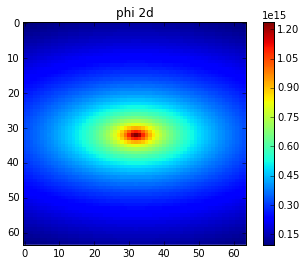

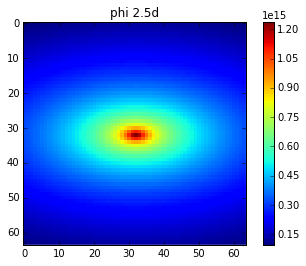

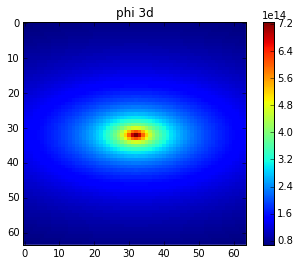

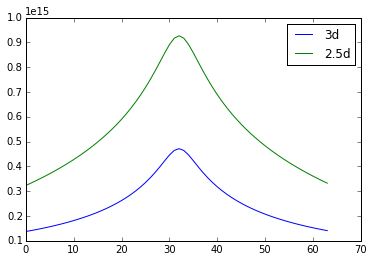

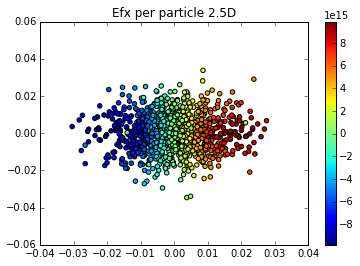

In [28]:
plt.figure()
plt.title('phi 2d')
plt.imshow(phi_2, interpolation='none')
plt.colorbar()
plt.show()
plt.figure()
plt.title('phi 2.5d')
plt.imshow(phi_25[slicenr,:,:], interpolation='none')
plt.colorbar()
plt.show()
plt.figure()
plt.title('phi 3d')
plt.imshow(phi[slicenr,:,:], interpolation='none')
plt.colorbar()
plt.show()

#print phi[slicenr,:,:]/phi_25
plt.figure()
plt.plot(phi[slicenr,slicenr,:], label='3d')
plt.plot(phi_25[slicenr,slicenr,:], label='2.5d')
plt.legend()
plt.show()

plt.title('Efx per particle 2.5D')
plt.scatter(xx.get()[0:1000],yy.get()[0:1000], c=Ex_25[0:1000])
plt.colorbar()
plt.show()



In [29]:
rho_time = gpuarray.to_gpu(rho_25)
poissonsolver_25_fast = FFT.GPUFFTPoissonSolver_2_5D(mesh, save_memory=False)
poissonsolver_25_slow = FFT.GPUFFTPoissonSolver_2_5D(mesh, save_memory=True)
pic_25_fast = PIC(mesh, poissonsolver_25_fast, context=context)
pic_25_slow = PIC(mesh, poissonsolver_25_slow, context=context)


In [30]:
%timeit pic_25_fast.poisson_solve(rho_time)

100 loops, best of 3: 3.63 ms per loop


In [31]:
%timeit pic_25_slow.poisson_solve(rho_time)

100 loops, best of 3: 20.9 ms per loop
